In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier
from sklift.models import ClassTransformation
from sklift.models import TwoModels

%%time


UsageError: Line magic function `%%time` not found.


In [2]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [6]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [33]:
df.loc[df['treatment'] == 'Buy One Get One', 'treatment'] = 1
df.loc[df['treatment'] == 'Discount', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [37]:
df_train = df[['treatment', 'target']]
df_features = df.drop(['treatment', 'target'], axis = 1)

In [43]:
X_train = df_features
y_train = df_train['target']
treat_train = df_train['treatment']

In [47]:
X_val = df_features
y_val = df_train['target']
treat_val =  df_train['treatment']

In [48]:
X_train_full = df_features
y_train_full = df_train['target']
treat_train_full = df_train['treatment']

In [49]:
X_test = df_features

### S learner

In [57]:
cat_features = X_train.columns[np.where(X_train.dtypes != float)[0]].values.tolist()

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [59]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


In [60]:
uplift_sm = sm.predict(X_val)

In [61]:
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

uplift@30%: 0.0893


In [62]:
models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

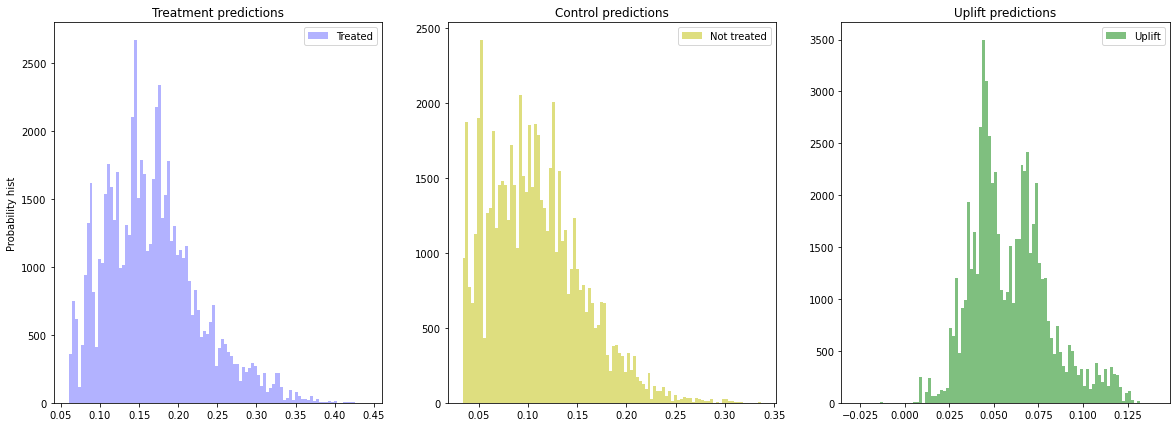

In [63]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [64]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,19.178579
1,treatment,17.746563
2,recency,15.741114
3,used_bogo,12.967020
4,used_discount,9.914879
5,zip_code,9.314490
6,history,8.453298
7,channel,6.684057


### трансформацией таргета

In [66]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

### Две независимые модели

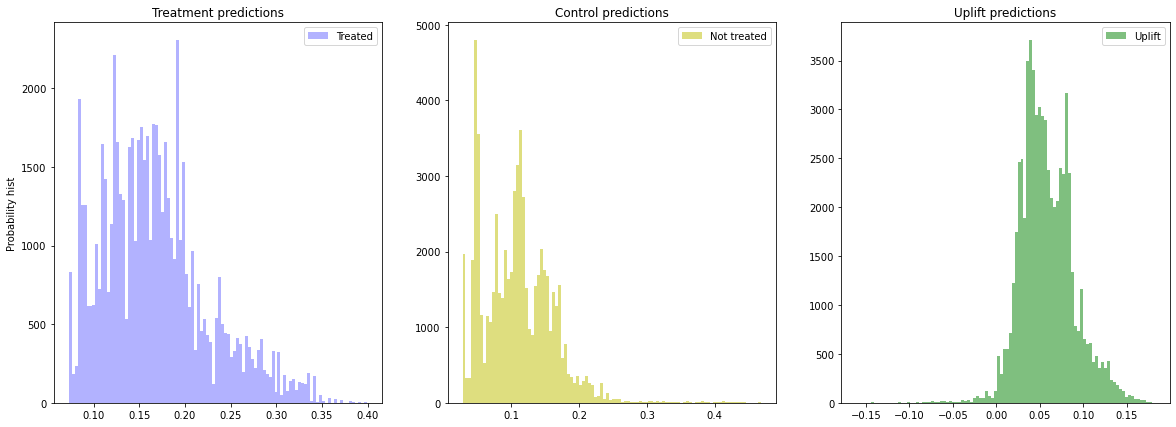

In [69]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [70]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
2,TwoModels,0.100739
3,TwoModels,0.100739
0,SoloModel,0.089350
1,ClassTransformation,0.085742
